### Authors: Théo Feder, Lucas Rouleau 



# <div align="center"><span style="color:red">Project 1 : VaR and ES </span></div>




 The aim of this project is to put into practice the concepts of Value at Risk and Expected Shortfall that we learned about in the Risk Management course.   
This project is divided into 5 main parts, which will be indicated throughout this notebook.

# 1) Build an investment Portfolio

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 

### Time series and assets weights

In [6]:
tickers = ['F', 'BAC']  # Ticker symbols for Ford and Bank of America 
weights = np.array([0.6, 0.4])  # Portfolio weights for Ford and Bank of America respectively


We import financial data with yfinance for our 2 stocks during 1 year, from 2023-02-15 to 2024-02-15: 

In [7]:
end_date = "2024-02-15"
start_date = "2023-02-15"

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data


[*********************100%***********************]  2 of 2 completed


,BAC,F
Date,,
2023-02-15,34.486229,12.112209
2023-02-16,34.214680,12.093474
2023-02-17,34.282566,12.074739
2023-02-21,33.477631,11.428380
2023-02-22,33.254578,11.437748
...,...,...
2024-02-08,33.119999,12.492906
2024-02-09,33.070000,12.346848
2024-02-12,33.619999,12.638965


### Daily returns and daily volatility

In [8]:
daily_returns = data.pct_change().dropna()

In [9]:
portfolio_daily_returns = daily_returns.dot(weights)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov(), weights)))


We plot the Portfolio daily returns and the Portfolio cumulative returns : 

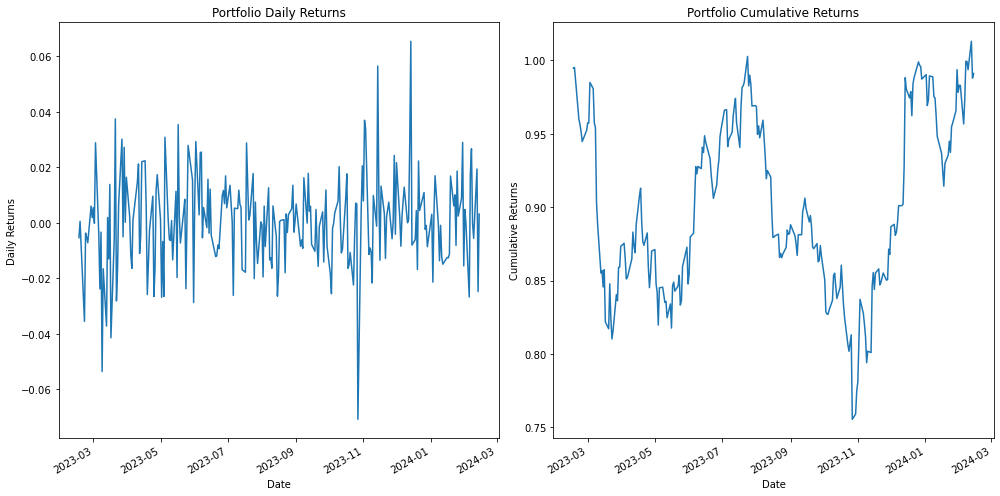

In [10]:
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
portfolio_daily_returns.plot(title='Portfolio Daily Returns')
plt.ylabel('Daily Returns')

cumulative_returns = (1 + portfolio_daily_returns).cumprod()
plt.subplot(1,2,2)
cumulative_returns.plot(title='Portfolio Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.tight_layout()
plt.show()


# 2) Compute daily VAR(10%) using different approaches: 

### 2.a : Parametric approach using SMA: 

Reminder : This approach assumes that the daily returns follow a normal distribution (mean = 0 and std dev = 1).   
This assumption implies that each VaR(X%) is associated with a critical Z-value which is given in the cumulative Z-table.  
In our case, we know that the Z value associated with a VaR(10%) is 1.28. 

To calculate the VaR(X%) and the VaR on a dollar basis we use the following formula: 


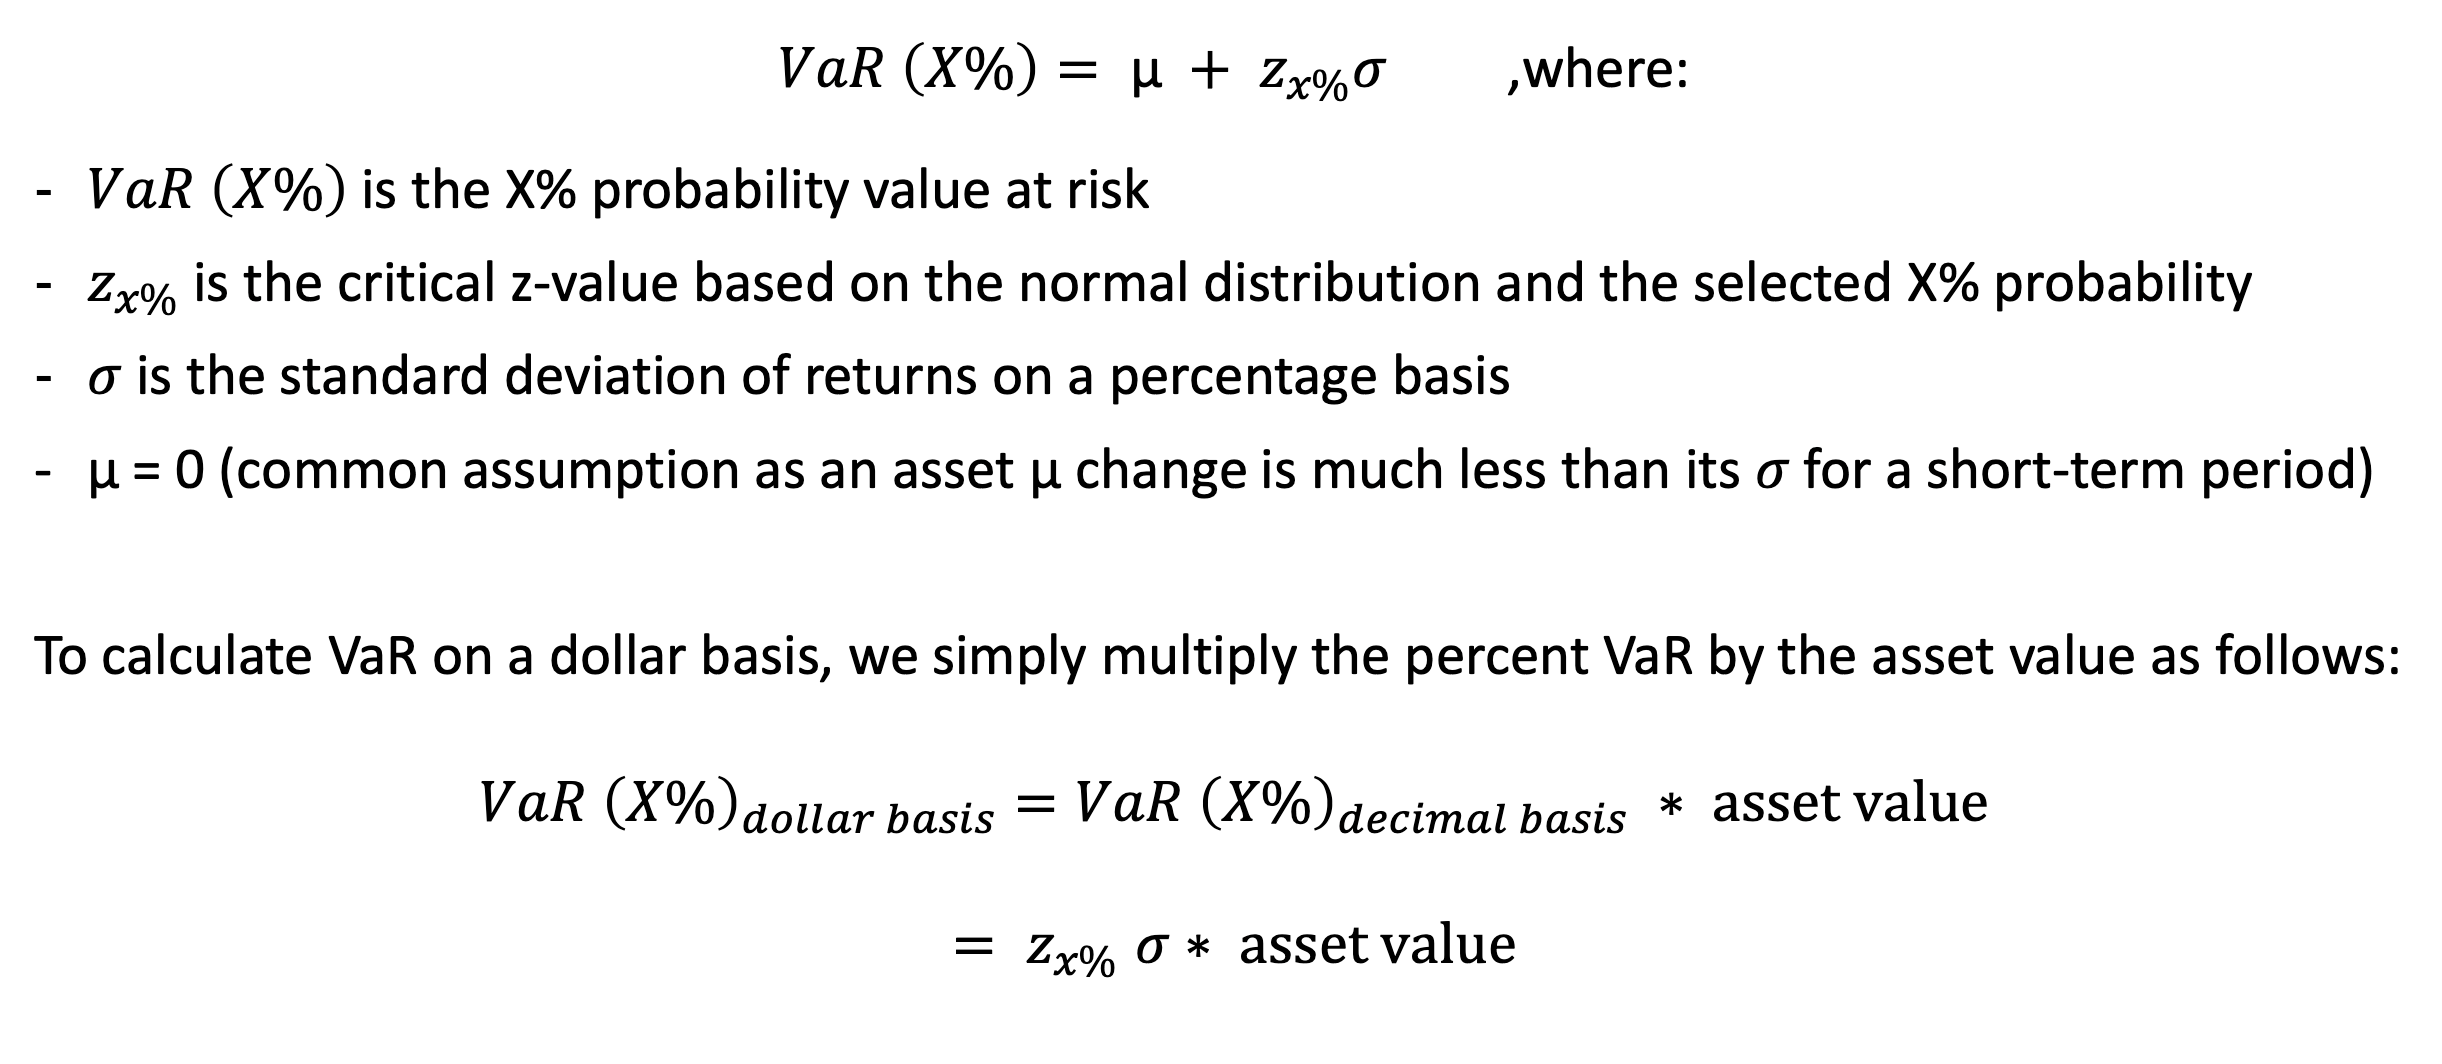

Among the parametric methods we are going to see (SMA and EWMA), the important point that differentiates them is the calculation of the variance. 


The SMA (Simple Moving Average) approach implies that the variance is calculated with equal weights for the returns, regardless of whether they are more recent or not.   
We have the following formula: 

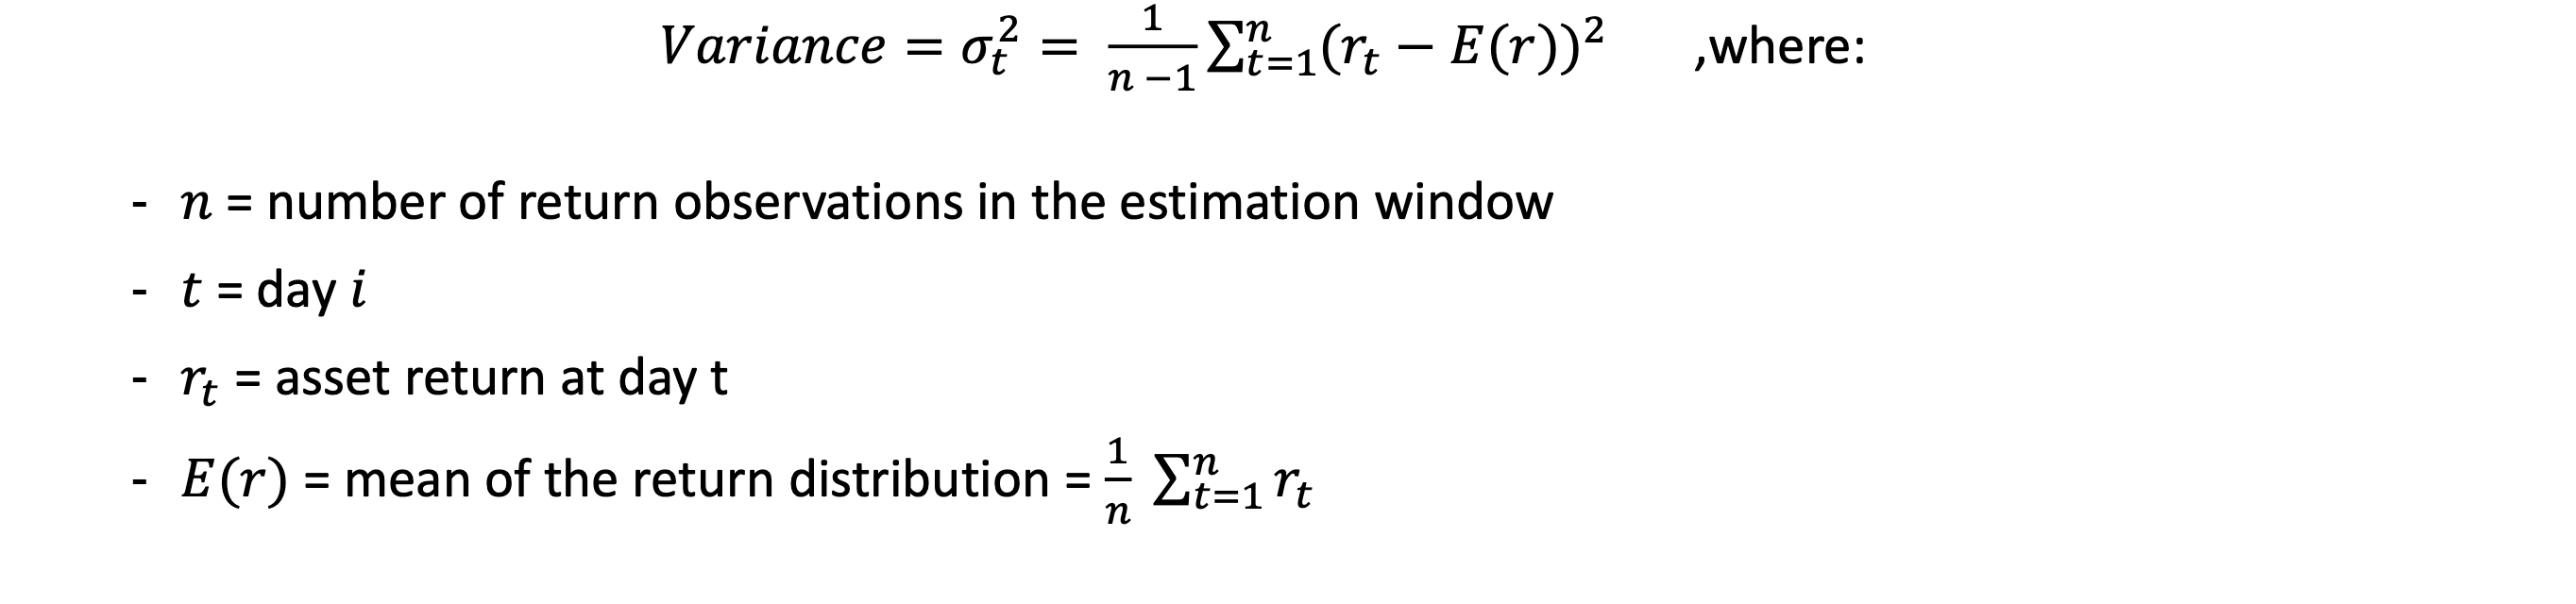

We replicate the formulas and we compute the VaR(10%) with our portfolio: 

/Users/lucasrouleau/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


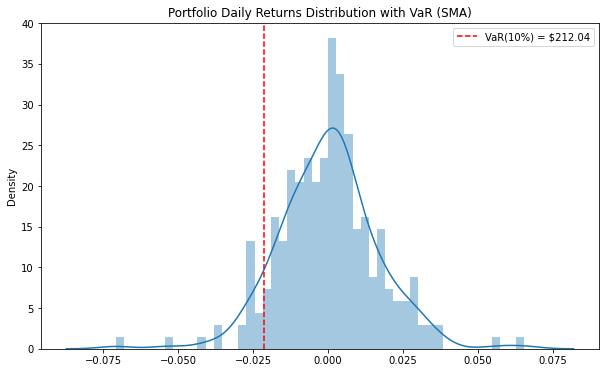

Results: 
VaR(10%) = 2.1204%
VaR(10%) (dollar basis) = $212.04


In [11]:
# Assuming 'portfolio_daily_returns' is your DataFrame of daily returns
#mean_returns = Mean of the return distribution : 
mean_returns = portfolio_daily_returns.mean()


#n = number of return observations in the estimation window : 
n = float(len(portfolio_daily_returns))


#We obtain the variance using SMA method: 
variance_sma = sum((portfolio_daily_returns - mean_returns) ** 2) / (n - 1)

#We then obtain the standard deviation: 
std_dev_sma = np.sqrt(variance_sma)


#After obtaining the standard deviation, we have to obtain the Z-value. As the daily return follows a normal distribution, we obtain a Z value equal to 1.28% with the cumulative Z-table 


# Z-score for 10% VaR
Z_score = 1.28  # For 10% VaR on one-tailed distribution

# Portfolio Value
portfolio_value = 10000  

#To calculate the dollar VaR (10%) we multiply the Z-value with the standard deviation and the portfolio value: 

# Calculate VaR
VaR_SMA = Z_score * std_dev_sma
VaR_SMA_dollar = Z_score * std_dev_sma  * portfolio_value


# Plotting
plt.figure(figsize=(10, 6))
sns.distplot(portfolio_daily_returns, bins=50, kde=True)
plt.axvline(-VaR_SMA, color='r', linestyle='--', label=f"VaR(10%) = ${VaR_SMA_dollar:.2f}")
plt.title('Portfolio Daily Returns Distribution with VaR (SMA)')
plt.legend()
plt.show()

print("Results: ")
print(f"VaR(10%) = {VaR_SMA * 100:.4f}%")
print(f"VaR(10%) (dollar basis) = ${VaR_SMA_dollar:.2f}")


According to the results, there is a 10% chance that the value loss of our 10000 dollars portfolio will reach or surpass 2.1204%, which corresponds to an amount of 212.04 dollars on any given day. 

### 2.b : Parametric approach using EWMA (Exponentially Weighted Moving Average)

We then compute the VaR (10%) with a parametric method but his time using an Exponentially Weighted Moving Average (EWMA) method in order to compute the variance. 

In contrast to the SMA method that gives equal weight to all observations, the EWMA method gives different weights to each return observation.

Indeed, this method gives  greater weight on more recent returns with a lambda parameter. 

A small value of lambda give more wieght to recent values, making the serie more sensitive to recent changes. In contrast, a higher value of lambda distribute more evenly the weights across the observations, the series is then less sensitive to recent change. 

We decided to set the lambda parameter to 0.94 which corresponds to an industry standard. As the lambda is close to 1, we gave in our analysis an important weight on older data, making the variance less sensitive to recent movements. 

The EWMA variance formula is the following: 

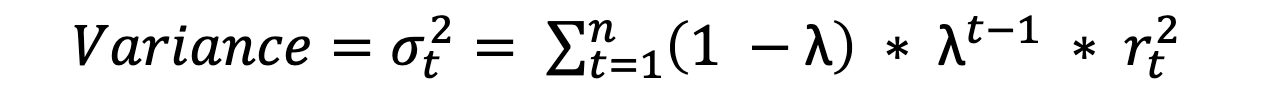

In [13]:
# Set lambda based on volatility of your data; a common choice is 0.94
lambda_param = 0.94

#We compute the variance: 
n = int(n)
t = pd.Series(range(1, n + 1))
t.index = portfolio_daily_returns.index

variance_ewma = sum((1 - lambda_param) * lambda_param ** (t - 1) * portfolio_daily_returns ** 2)
print ("The value of the variance with EWMA approach is : ")
print(variance_ewma)





The value of the variance with EWMA approach is : 
0.00036125862696489676


In [14]:
#After obtaining the variance_ewma we compute the standard deviation and the VaR: 
std_dev_ewma = np.sqrt(variance_ewma)

#VaR with ewma: 
VaR_EWMA = Z_score * std_dev_ewma
VaR_EWMA_dollar = VaR_EWMA * portfolio_value

print("Results: ")
print(f"VaR(10%) = {VaR_EWMA * 100:.4f}%")
print(f"VaR(10%) (dollar basis) = ${VaR_EWMA_dollar:.2f}")

Results: 
VaR(10%) = 2.4329%
VaR(10%) (dollar basis) = $243.29


/Users/lucasrouleau/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


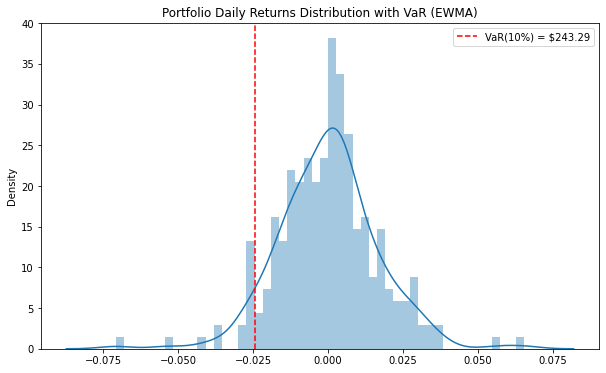

In [15]:
# Plotting
plt.figure(figsize=(10, 6))
sns.distplot(portfolio_daily_returns, bins=50, kde=True)
plt.axvline(-VaR_EWMA, color='r', linestyle='--',label=f"VaR(10%) = ${VaR_EWMA_dollar:.2f}")
plt.title('Portfolio Daily Returns Distribution with VaR (EWMA)')
plt.legend()
plt.show()

We understand with the results that there is a 10% chance that the value loss of our $10000 portfolio will reach or surpass:  

2.1124%, which corresponds to an amount of $211.24 on any given day. 

Compared to the parametric method without weights, the VaR(10%) for our portfolio is higher, it can suggest that the portfolio's recent returns have been relatively more volatile.  

### 2.c: Non parametric approach 

We then use another technique to compute the VaR(10%) of our portoflio: The Non-Parametric approach.  
Unlike the previous methods, this approach relies on historical data and doesn’t make assumptions on the distribution on the data.  
This method implies ordering the returns  and identify the lowest X% of the returns, here the 10% lowest returns.  

One of the benefit of this approach is that it is really easy to implement. This is why a lot of French banks use it. 

In [16]:
# Rank the portfolio daily returns from lowest to highest
sorted_returns = np.sort(portfolio_daily_returns)

#Calculate the quantile for the lowest 10% of returns
#We multiply the result of the VaR which is negative by -1 in order to have a positive percentage: 
VaR_non_parametric = np.percentile(sorted_returns, 10)*-1
VaR_non_parametric_dollar= VaR_non_parametric * portfolio_value

print("Results: ")
print(f"VaR(10%) = {VaR_non_parametric * 100:.4f}%")
print(f"VaR(10%) (dollar basis) = ${VaR_non_parametric_dollar:.2f}") 

Results: 
VaR(10%) = 1.8470%
VaR(10%) (dollar basis) = $184.70


Comments on the results: We understand with the results that there is a 10% chance that the value loss of our $10000 portfolio will reach or surpass: 

1.8470%, which corresponds to an amount of $184.70 on any given day. 

With this non parametric method we obtain a VaR that is inferior to both Parametric approach. 

/Users/lucasrouleau/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


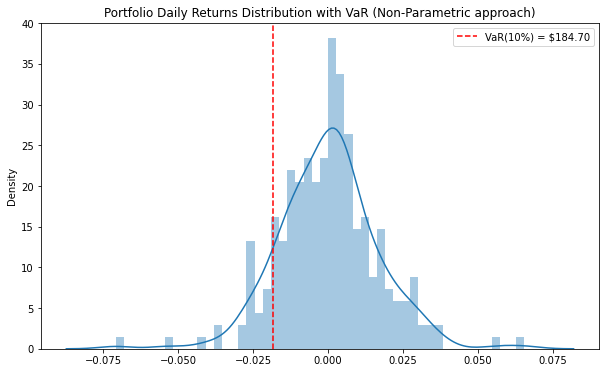

In [17]:
# Plotting
plt.figure(figsize=(10, 6))
sns.distplot(portfolio_daily_returns, bins=50, kde=True)
plt.axvline(-VaR_non_parametric, color='r', linestyle='--', label=f"VaR(10%) = ${VaR_non_parametric_dollar:.2f}")
plt.title('Portfolio Daily Returns Distribution with VaR (Non-Parametric approach)')
plt.legend()
plt.show()

### 2.d :  Hybrid Approach

The hybrid approach is a method that combines the techniques from the previpus approaches wa have seen previously to estimate the volatilty. 

Indeed, the Hybrid approach uses historical data like in the non-parametric approach but also uses weights on the returns like in the Parametric approach (EWMA). 

To implement this approach we have to : 

1) Assign weights for each histrocial return strating from the most recent return, using an approach similar to that of the EWMA method. 

2) Order the returns from highest to lowest (similar to the Non-Parametric approach)

3) Determine the VaR for the portfolio starting with the lowest return and by accumulating the respective hybrid wieghts of historical returns until the VaR(10%) percentage is reached. 


#### Step 1: Assign weights. We want to implement the following formula : 

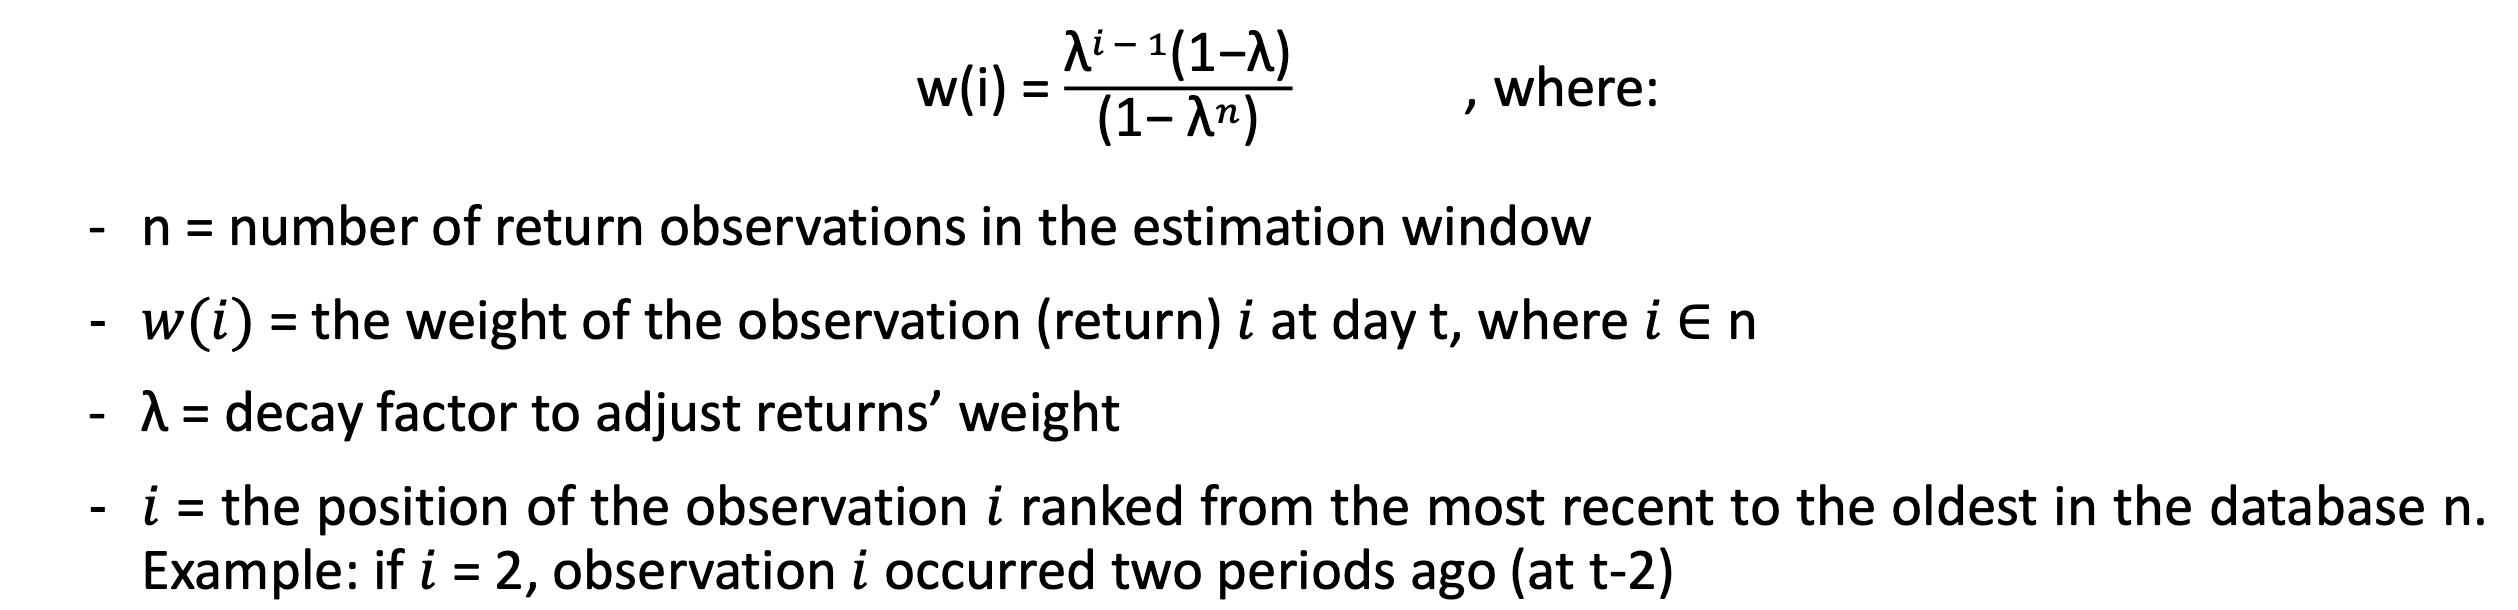

In [18]:
#Invert the dataframe to have the most recent first: 
portfolio_daily_returns_invert = portfolio_daily_returns.iloc[::-1]


In [19]:
#We already have all the parameters to replicathe this formula: 
# -t = Position of the observation from most recent to oldest return (i in the formula)
# -lambda_param =  The lambda variable
# -n = Number of return observations in our analysis (n = 250)

#Computation of the wieghts: 
weights_hybrid = (lambda_param ** (t - 1) * (1 - lambda_param)) / (1 - lambda_param ** n)

weights_hybrid.index= portfolio_daily_returns_invert.index

#Assignment of the weights to the returns 
weighted_hybrid_returns = portfolio_daily_returns_invert * weights_hybrid

#### Step 2= Order the hybrid returns from the highest to the lowest : 

In [20]:
sorted_weighted_hybrid_returns = weighted_hybrid_returns.sort_values( ascending=False)

#### Step 3: Determine the VaR(10%) 
In order to do so we have to order our returns calculated previously from the lowest to the highest and by cumulating hybrid weights 𝑤(𝑖) of the historical returns until the  𝑉𝑎𝑅 (10%) percentage is reached. 

In [21]:
#We sort the returns : 
sorted_weighted_hybrid_returns = sorted_weighted_hybrid_returns[::-1]

#We create a dataframe with the returns and their associated wieght 
df_hybrid = pd.DataFrame({
    'Weights_Hybrid': weights_hybrid,
    'Sorted_Weighted_Hybrid_Returns': sorted_weighted_hybrid_returns
})

# Sort the DataFrame by the 'Sorted_Weighted_Hybrid_Returns' column from lowest to highest
df_hybrid = df_hybrid.sort_values(by='Sorted_Weighted_Hybrid_Returns', ascending=True)

# We alculate the cumulative sum of the 'Weights_Hybrid' column
df_hybrid['cumulative_weights_hybrid'] = df_hybrid['Weights_Hybrid'].cumsum()

#We drop the index 
df_hybrid= df_hybrid.reset_index()

# Find the index of the first value greater than 0.1 in 'cumulative_weights_hybrid'
index_sup = df_hybrid[df_hybrid['cumulative_weights_hybrid'] > 0.1].index[0]

# Get the index of the immediately preceding value
index_inf = index_sup - 1 if index_sup > 0 else index_sup

# Extract the 'cumulative_weights_hybrid' and 'Sorted_Weighted_Hybrid_Returns' values
value_inf_cumulative_weights_hybrid = df_hybrid.loc[index_inf, 'cumulative_weights_hybrid']
value_sup_cumulative_weights_hybrid = df_hybrid.loc[index_sup, 'cumulative_weights_hybrid']
value_inf_Sorted_Weighted_Hybrid_Returns = df_hybrid.loc[index_inf, 'Sorted_Weighted_Hybrid_Returns']
value_sup_Sorted_Weighted_Hybrid_Returns = df_hybrid.loc[index_sup, 'Sorted_Weighted_Hybrid_Returns']

# Display the results
print(f"The 0.1 (10%) interval in 'cumulative_weights_hybrid'is: [{value_inf_cumulative_weights_hybrid}, {value_sup_cumulative_weights_hybrid}]")
print("")
print(f"The corresponding values in 'Sorted_Weighted_Hybrid_Returns' are: [{value_inf_Sorted_Weighted_Hybrid_Returns}, {value_sup_Sorted_Weighted_Hybrid_Returns}]")


The 0.1 (10%) interval in 'cumulative_weights_hybrid'is: [0.09530867389454034, 0.12762558692599724]

The corresponding values in 'Sorted_Weighted_Hybrid_Returns' are: [-0.0010398981486465164, -0.0005005734386956059]


A linear Interpolation is necessary to find the VaR(10%) with the values we obtained: 

In [22]:
#Linear Interpolation to find the Var(10%): 


x = 0.1

# Applying the linear interpolation formula to find the VaR(10%)
VaR_hybrid = -1*(value_inf_Sorted_Weighted_Hybrid_Returns + ((x - value_inf_cumulative_weights_hybrid) * (value_sup_Sorted_Weighted_Hybrid_Returns - value_inf_Sorted_Weighted_Hybrid_Returns)) / (value_sup_cumulative_weights_hybrid - value_inf_cumulative_weights_hybrid))
VaR_hybrid_dollar = VaR_hybrid * portfolio_value
print(f"The value of the VaR(10%) using an hybrid method is: {VaR_hybrid}")
print ("")
print("Results: ")
print(f"VaR(10%) = {VaR_hybrid * 100:.4f}%")
print(f"VaR(10%) (dollar basis) = ${VaR_hybrid_dollar:.2f}") 

The value of the VaR(10%) using an hybrid method is: 0.0009616063857962295

Results: 
VaR(10%) = 0.0962%
VaR(10%) (dollar basis) = $9.62


Despite having applied the formulas to implement this approach, we realise that there is a problem with this method. 
The value of the VaR(10%) is too low compared with the other methods used previously.


However, we have not managed to fix this problem, which is the main limitation of our analysis. 

### 2.e: Monte Carlo simulation (based on parametric SMA approach)

#### Reminder: 

A Monte Carlo simulation selects a variable subject to uncertainty and allocates a random value to it. 
The model is executed and a result is run.

This procedure is replicated multiple times, each time applying various values to the specified variable. 

After completing the simulation, the outcomes are aggregated to deduce an average estimate, in our cas of the VaR. 



The objective is to generate 10,000 random standard deviations based on the previously calculated SMA standard deviation. 


To calculate the VaR with the Monte Carlo approach we use the fonction np.random.normal() that draw random samples from a normal distribution. It has 3 parameters: 

1. The mean of the distribution: We will use mean_returns, which is the mean of the returns of our portfolio.

2. The standard deviation: We will use the standard deviation calculated with the SMA approach 

3. Size: The number of samples to draw: We will use 10 000 simulations 

In [21]:
# Number of simulations
num_simulations = 10000

# Simulate 10000 portfolios daily returns 
simulated_returns = np.random.normal(mean_returns,std_dev_sma,  size=num_simulations)

#Calculate the VaR(10%)
VaR_MC = np.percentile(simulated_returns, 10)*-1
VaR_MC_dollar = VaR_MC* portfolio_value

print("Results: ")
print(f"VaR(10%) with Monte Carlo approach = {VaR_MC * 100:.4f}%")
print(f"VaR(10%) with Monte Carlo approach (dollar basis) = ${VaR_MC_dollar:.2f}") 



Results: 
VaR(10%) with Monte Carlo approach = 2.0981%
VaR(10%) with Monte Carlo approach (dollar basis) = $209.81


C:\Users\tfeder\AppData\Local\Temp\ipykernel_21172\1116457152.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(simulated_returns, bins=50, kde=True)


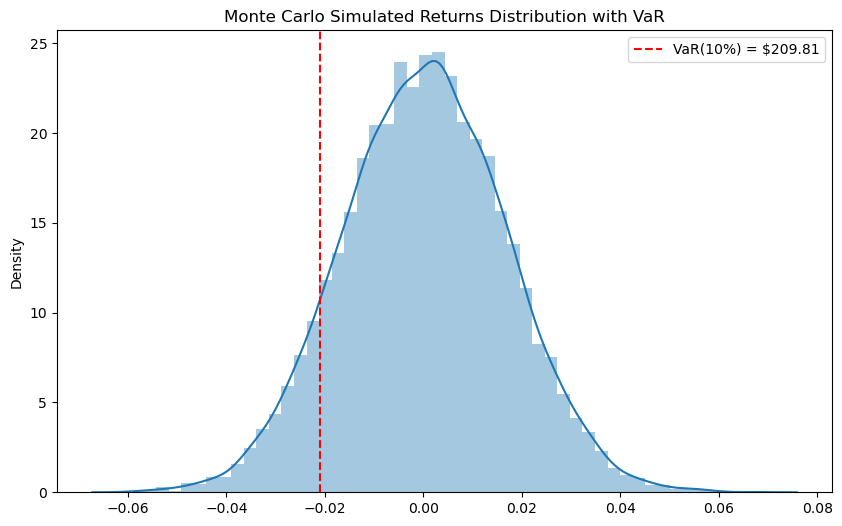

In [22]:
# Plotting the simulated returns distribution
plt.figure(figsize=(10, 6))
sns.distplot(simulated_returns, bins=50, kde=True)
plt.axvline(-VaR_MC, color='r', linestyle='--', label=f"VaR(10%) = ${VaR_MC_dollar:.2f}")
plt.title(f'Monte Carlo Simulated Returns Distribution with VaR')
plt.legend()
plt.show()

According to the results, there is a 10% chance that the value loss of our 10000 dollars portfolio will reach or surpass 2.0981%, which corresponds to an amount of $209.81 dollars on any given day.



##### At the end of this second part, we note that the values obtained with the different approaches are relatively close to each other, apart from the hybrid approach which caused problems. 

##### We obtain VaR(10%) values that vary between 1.847% and 2.0981% of our portfolio, i.e. an amount that varies between: 184.70 and 243.29 dollars. 

# 3) VAR conversions (SMA approach)

### 3.A) Calculate the weekly, monthly and annual SMA VaR(10%)

We have previously calculated the VaR(10%) at a daily basis using the SMA approach. To do these conversion we just have to multiply our result by: 

    - √5 for a weekly conversion
    
    - √20 for a weekly conversion
    
    - √250 for a weekly conversion: 

In [23]:

# Calculate VaR for different time periods at 10% confidence level
VaR_weekly_10 = VaR_SMA * np.sqrt(5)
VaR_weekly_10_dollar = VaR_SMA_dollar* np.sqrt(5)

VaR_monthly_10 = VaR_SMA * np.sqrt(22)
VaR_monthly_10_dollar = VaR_SMA_dollar* np.sqrt(22)

VaR_annual_10 = VaR_SMA * np.sqrt(252)
VaR_annual_10_dollar = VaR_SMA_dollar* np.sqrt(252)

# Presenting the results
print(f"The weekly VaR(10%) is {VaR_weekly_10*100:.4f}% or ${VaR_weekly_10_dollar:.2f}.")
print("")
print(f"The monthly VaR(10%) is {VaR_monthly_10*100:.4f}% or ${VaR_monthly_10_dollar:.2f}.")
print("")
print(f"The yearly VaR(10%) is {VaR_annual_10*100:.4f}% or ${VaR_annual_10_dollar:.2f}.")

The weekly VaR(10%) is 4.7414% or $474.14.

The monthly VaR(10%) is 9.9457% or $994.57.

The yearly VaR(10%) is 33.6606% or $3366.06.



We understand with the results that there is a 10% chance that the value loss of our $10,000 portfolio will reach or surpass:

4.7414%  or $474.14 on any given week,

9.9457% or $994.57 on any given month,

33.6606% or $3366.06 on any given year.


### 3.B) Convert VaR from 10% to 1% confidence level

To convert a VaR(10%) to a VaR(1%) we have to use the following formula : 

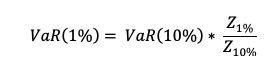

In [24]:
#We know that the Z value at 10% is 1.28 with our variable Z_score. At a 1% level the Z score is 2.33

Z_1 = 2.33

VaR_daily_1 = VaR_SMA * (Z_1 / Z_score)
VaR_daily_1_dollar = VaR_SMA_dollar * (Z_1 / Z_score)

VaR_weekly_1 = VaR_weekly_10 * (Z_1 / Z_score)
VaR_weekly_1_dollar = VaR_weekly_10_dollar * (Z_1 / Z_score)

VaR_monthly_1 = VaR_monthly_10 * (Z_1 / Z_score)
VaR_monthly_1_dollar = VaR_monthly_10_dollar * (Z_1 / Z_score)

VaR_annual_1 = VaR_annual_10 * (Z_1 / Z_score)
VaR_annual_1_dollar = VaR_annual_10_dollar * (Z_1 / Z_score)


# Presenting the results
print(f"At a 1% level the VaR at a daily level is {VaR_daily_1*100:.4f}% or ${VaR_daily_1_dollar:.2f}.")
print("")
print(f"At a 1% level the VaR at a weekly level is {VaR_weekly_1*100:.4f}% or ${VaR_weekly_1_dollar:.2f}.")
print("")
print(f"At a 1% level the VaR at a  monthly level is {VaR_monthly_1*100:.4f}% or ${VaR_monthly_1_dollar:.2f}.")
print("")
print(f"At a 1% level the VaR at an annual is {VaR_annual_1*100:.4f}% or ${VaR_annual_1_dollar:.2f}.")

At a 1% level the VaR at a daily level is 3.8598% or $385.98.

At a 1% level the VaR at a weekly level is 8.6308% or $863.08.

At a 1% level the VaR at a  monthly level is 18.1042% or $1810.42.

At a 1% level the VaR at an annual is 61.2728% or $6127.28.


We understand with the results that there is a 1% chance that the value loss of our $10000 portfolio will reach or surpass:

3.8598% or $385.98 on any given day,

8.6308% or $863.08 on any given week, 

18.1042% or $1810.42 on any given month, 

61.2729% or $6127.29 on any given year.



We notice that the potential losses for a VaR(1%) are much bigger than the VaR(10%), which is logical as the VaR(1%) represens the threshold that will not be exceeded at a 99% confidence level. 

# 4) Stressed VaR(10%) (Non-parametric approach)


Reminder: 
Stress testing involves testing the performance of a model during “stressed” time periods (crises).  
To calculate a stressed VaR we calculate the VaR on a “stressed” time period, here with data of 1 year during stressed economic conditions.  


For our analysis we will use data from 2008-01-01 to 2009-01-01 in order to capture the impact of the subprimes crisis

In [25]:
#Import the data

stressed_end_date = "2009-01-01"
stressed_start_date = "2008-01-01"

data_stressed = yf.download(tickers, start=stressed_start_date, end=stressed_end_date)['Adj Close']

data_stressed

[*********************100%***********************]  2 of 2 completed


,BAC,F
Date,,
2008-01-02,30.370268,3.798859
2008-01-03,30.175564,3.712520
2008-01-04,29.838627,3.528334
2008-01-07,29.876060,3.545602
2008-01-08,28.760395,3.511066
...,...,...
2008-12-24,10.956812,1.214483
2008-12-26,10.819141,1.318089
2008-12-29,10.479024,1.277798


### Weights, Daily returns and VaR computation

In [26]:
stressed_daily_returns = data_stressed.pct_change().dropna()
stressed_portfolio_daily_returns = stressed_daily_returns.dot(weights)

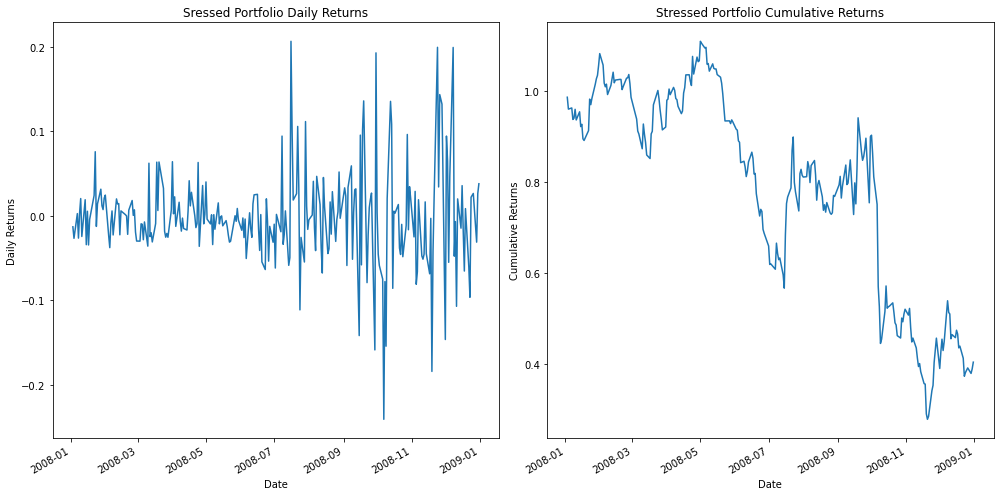

In [27]:
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
stressed_portfolio_daily_returns.plot(title='Sressed Portfolio Daily Returns')
plt.ylabel('Daily Returns')

cumulative_returns = (1 + stressed_portfolio_daily_returns).cumprod()
plt.subplot(1,2,2)
cumulative_returns.plot(title='Stressed Portfolio Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.tight_layout()
plt.show()

In [28]:
# Rank the portfolio daily returns from lowest to highest
stressed_sorted_returns = np.sort(stressed_portfolio_daily_returns)

#Calculate the quantile for the lowest 10% of returns
#We multiply the result of the VaR which is negative by -1 in order to have a positive percentage: 
stressed_VaR_non_parametric = np.percentile(stressed_sorted_returns, 10)*-1
stressed_VaR_non_parametric_dollar= stressed_VaR_non_parametric * portfolio_value

print("Results: ")
print(f"Stressed VaR(10%) = {stressed_VaR_non_parametric * 100:.4f}%")
print(f"Stressed VaR(10%) (dollar basis) = ${stressed_VaR_non_parametric_dollar:.2f}") 

Results: 
Stressed VaR(10%) = 5.4935%
Stressed VaR(10%) (dollar basis) = $549.35


In [29]:
# Comparison with non-parametric VaR in 2): 

#Computation of the "stressed_computation"
coeff_stressed = stressed_VaR_non_parametric/VaR_non_parametric
coeff_stressed
print(f"Stressed VaR(10%) = {stressed_VaR_non_parametric * 100:.4f}%")
print(f"Non-stressed VaR(10%)  = {VaR_non_parametric * 100:.4f}%")
print("")
print(f"Stressed VaR(10%) (dollar basis) = ${stressed_VaR_non_parametric_dollar:.2f}")
print(f"Non-stressed VaR(10%) (dollar basis) = ${VaR_non_parametric_dollar:.2f}")
print("")
print(f"The stressed coefficient is equal to {coeff_stressed}")

Stressed VaR(10%) = 5.4935%
Non-stressed VaR(10%)  = 1.8470%

Stressed VaR(10%) (dollar basis) = $549.35
Non-stressed VaR(10%) (dollar basis) = $184.70

The stressed coefficient is equal to 2.974281256115288


We observe that during the subprimes crisis the VaR(10%) if our portfolio has been multiplied by almost 3.


This sharp increase in Value at Risk during a crisis like the subprime crisis in 2008-2009 is caused by the increase in financial market volatility and the drop in stock values.  
This increase in VaR is all the more significant as the two stocks in our portfolio (Bank of America and Ford) were heavily affected by this crisis.

# 5) Expected Shortfall CVaR (5%) using both parametric and non-parametric approaches

In [33]:
from scipy.stats import norm

# Define the function to calculate CVaR using the parametric approach
def calculate_parametric_cvar(mean_return, std_dev, confidence_level):
    """
    Calculate the Conditional Value at Risk (CVaR) using the parametric approach.

    :param mean_return: The mean return of the portfolio
    :param std_dev: The standard deviation of the portfolio returns
    :param confidence_level: The confidence level as a decimal (e.g., 0.95 for 95%)
    :return: CVaR at the given confidence level
    """
    # Z-score for the desired confidence level
    z_score = -norm.ppf(1 - confidence_level)
    
    # Calculate the CVaR using the parametric formula
    cvar = mean_return + (std_dev * z_score ** 2) / (1 - confidence_level) * \
           (np.exp(-0.5 * z_score ** 2) / np.sqrt(2 * np.pi))
    
    return cvar

# Calculate the parametric CVaR at the 5th percentile
cvar_5_parametric = calculate_parametric_cvar(mean_returns, std_dev_sma, 0.95)

# Display the calculated parametric CVaR
print("The value of the calculated parametric CVaR is : ")
print(cvar_5_parametric)



The value of the calculated parametric CVaR is : 
0.0925503579551261


In [31]:
# For the non-parametric approach, we'll define a function to calculate CVaR based on historical data.
# We'll assume we have a sorted array of returns from the actual portfolio data.

def calculate_non_parametric_cvar(sorted_returns, confidence_level):
    """
    Calculate the Conditional Value at Risk (CVaR) using the non-parametric approach.

    :param sorted_returns: An array of portfolio returns sorted from worst to best
    :param confidence_level: The confidence level as a decimal (e.g., 0.95 for 95%)
    :return: CVaR at the given confidence level
    """
    # Number of returns in the tail (below the VaR threshold)
    num_returns_in_tail = int((1 - confidence_level) * len(sorted_returns))
    
    # Calculate the average of the returns in the tail (the worst 5% of cases)
    cvar = -np.mean(sorted_returns[:num_returns_in_tail])
    
    return cvar

# Calculate the non-parametric CVaR at the 5th percentile
cvar_5_non_parametric = calculate_non_parametric_cvar(sorted_returns, 0.95)

# Display the calculated non-parametric CVaR
print("The value of the calculated non-parametric CVaR is : ")
print(cvar_5_non_parametric)


The value of the calculated non-parametric CVaR is : 
0.03569695880501727


### Expected Shortfall (CVaR) Calculation Methodologies

#### Parametric Approach:

The parametric approach assumes that returns are normally distributed. The Expected Shortfall (CVaR) at a certain confidence level is the average of the expected losses that are worse than the Value at Risk (VaR) at that confidence level. Mathematically, it is expressed as follows:

$$
CVaR_{X\%} = \mu + \frac{\sigma z_{X\%}^2 e^{-\frac{1}{2}z_{X\%}^2}}{\sqrt{2\pi}(1-\alpha)}
$$

where:

- $ \mu $ is the mean return, which is often assumed to be zero for a short-term period.
- $ \sigma $ is the standard deviation of returns.
- $ z_{X\%} $ is the z-score corresponding to the X% percentile in the normal distribution.
- $ \alpha $ is the confidence level (e.g., 0.95 for a 5% CVaR).
- The z-score is found using the inverse of the cumulative distribution function (CDF) of the standard normal distribution, using statistical tables or functions such as `norm.ppf` in Python.

#### Non-Parametric Approach:

The non-parametric approach does not assume any specific distribution of returns. Instead, it calculates the CVaR directly from historical return data. The CVaR is determined by averaging the returns that are worse than the VaR at the specified percentile. The formula is given by:

$$
CVaR_{X\%} = -\frac{1}{N} \sum_{i=1}^{N} R_i
$$

where:

- $ N $ is the number of returns in the worst X%.
- $ R_i $ are the sorted returns from the worst to the best.
- In the non-parametric method, you simply calculate the average of the worst 5% of the sorted returns to get the CVaR.


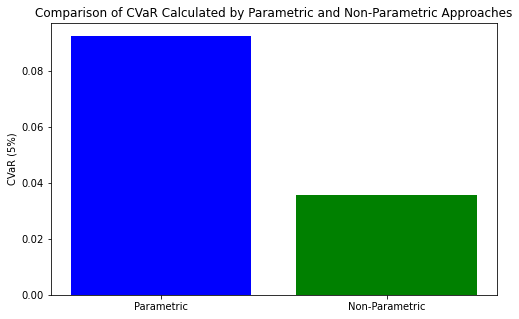

In [32]:
import matplotlib.pyplot as plt

# CVaR values from your calculations
cvar_values = [0.0925503714228508, 0.03569696293595986]
approaches = ['Parametric', 'Non-Parametric']

plt.figure(figsize=(8, 5))
plt.bar(approaches, cvar_values, color=['blue', 'green'])
plt.ylabel('CVaR (5%)')
plt.title('Comparison of CVaR Calculated by Parametric and Non-Parametric Approaches')
plt.show()


The parametric approach yielded a higher CVaR at 5% (approximately **9.26%**) compared to the non-parametric approach (approximately **3.57%**). This suggests that, under the parametric model's assumptions (**i.e., normally distributed returns**), the expected loss in the worst 5% of cases is higher than what is observed directly from the historical data without assuming any specific distribution (non-parametric approach).

The parametric approach to CVaR estimation **assumes normally distributed returns**, thus sensitive to deviations like **skewness or kurtosis**. In contrast, the non-parametric method **doesn't assume distribution**, possibly providing a more accurate reflection of historical loss potential. Parametric estimation relies on **mean and standard deviation estimates**, sensitive to outliers and recent market conditions, while the non-parametric method depends solely on **historical returns**, potentially offering robustness but reliant on historical data quality and breadth.

The higher CVaR from the parametric approach indicates a more **conservative risk estimation**, which may appeal to **risk-averse investors**. On the other hand, the lower CVaR from the non-parametric approach might attract investors focusing on **historical performance** without strong assumptions about future return distributions.
